# Membership Inference Attacks on Fine-Tuned LLMs

**Phases 3–8: Tokenization → Training → MIA → Evaluation → Visualization → Sanity Checks**

This notebook is designed to run on **Google Colab with a GPU runtime**.

**Pre-requisites:** Upload `data/train.jsonl`, `data/val.jsonl`, and `data/nonmember.jsonl` (generated locally by `src/generate_dataset.py`).

**Research Questions:**
- **RQ1:** Does overfitting increase membership inference success?
- **RQ2:** Are rare training samples more vulnerable to membership inference?

---
## Phase 1 — Environment Setup (Colab)

In [1]:
# 1.1 — Install dependencies
!pip install -q torch transformers datasets accelerate scikit-learn matplotlib numpy pandas tqdm wandb

In [2]:
# 1.2 — Verify GPU
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available:  {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device:      {torch.cuda.get_device_name(0)}")
    print(f"GPU memory:      {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device:    {DEVICE}")

PyTorch version: 2.10.0+cu128
CUDA available:  True
GPU device:      NVIDIA A100-SXM4-40GB
GPU memory:      42.4 GB
Using device:    cuda


In [3]:
# 1.3 — Fix all random seeds for reproducibility
import random
import numpy as np

SEED = 42

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)
print(f"✓ All seeds fixed to {SEED}")

✓ All seeds fixed to 42


In [4]:
# 1.3b — Weights & Biases setup
import wandb

WANDB_PROJECT = "mia-llm"       # project name on wandb.ai
WANDB_ENTITY  = None            # set to your wandb username/team, or leave None

# Login — will prompt for API key on first run (get yours at https://wandb.ai/authorize)
wandb.login()
print(f"✓ W&B logged in  |  project: {WANDB_PROJECT}")

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.
wandb: Currently logged in as: minh1008 (minh1008-ludwig-maximilianuniversity-of-munich) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✓ W&B logged in  |  project: mia-llm


In [5]:
# 1.4 — Mount Google Drive and set up project directory
import os

# Mount Google Drive (will prompt for auth on Colab)
try:
    from google.colab import drive
    drive.mount("/content/drive")
    PROJECT_DIR = "/content/drive/MyDrive/DataEthicSecurity"
    print(f"✓ Google Drive mounted. Project dir: {PROJECT_DIR}")
except ImportError:
    PROJECT_DIR = "."
    print(f"Not on Colab — using local directory: {PROJECT_DIR}")

# Create all required directories
for d in ["data", "models/regularized", "models/overfitted", "results/plots"]:
    os.makedirs(os.path.join(PROJECT_DIR, d), exist_ok=True)

# Change working directory so all relative paths resolve correctly
os.chdir(PROJECT_DIR)
print(f"✓ Working directory: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted. Project dir: /content/drive/MyDrive/DataEthicSecurity
✓ Working directory: /content/drive/MyDrive/DataEthicSecurity


In [6]:
# 1.5 — Generate synthetic dataset (17,000 clinical notes)
# Produces: data/train.jsonl (10K), data/val.jsonl (2K), data/nonmember.jsonl (5K)

import json
import random

SEED = 42

# ──────────────── Vocabulary pools ────────────────

COMMON_CONDITIONS = [
    "hypertension", "pneumonia", "type 2 diabetes", "lower back pain",
    "urinary tract infection", "gastroesophageal reflux disease", "asthma",
    "iron deficiency anemia", "migraine", "osteoarthritis",
]

RARE_CONDITIONS = [
    "Addison's disease", "Marfan syndrome", "autoimmune encephalitis",
    "primary biliary cholangitis", "systemic mastocytosis", "Castleman disease",
    "stiff person syndrome", "POEMS syndrome",
    "paraneoplastic cerebellar degeneration", "Erdheim-Chester disease",
]

SYMPTOMS = {
    "hypertension": ["headache", "dizziness", "blurred vision", "shortness of breath", "chest tightness"],
    "pneumonia": ["fever", "productive cough", "chest pain", "fatigue", "shortness of breath"],
    "type 2 diabetes": ["polyuria", "polydipsia", "blurred vision", "fatigue", "slow wound healing"],
    "lower back pain": ["lumbar stiffness", "radiating leg pain", "muscle spasm", "reduced range of motion", "tenderness"],
    "urinary tract infection": ["dysuria", "urinary frequency", "suprapubic pain", "cloudy urine", "low-grade fever"],
    "gastroesophageal reflux disease": ["heartburn", "regurgitation", "dysphagia", "chest discomfort", "chronic cough"],
    "asthma": ["wheezing", "shortness of breath", "chest tightness", "nocturnal cough", "exercise intolerance"],
    "iron deficiency anemia": ["fatigue", "pallor", "palpitations", "cold extremities", "exertional dyspnea"],
    "migraine": ["unilateral headache", "photophobia", "phonophobia", "nausea", "visual aura"],
    "osteoarthritis": ["joint pain", "morning stiffness", "crepitus", "swelling", "reduced mobility"],
    "Addison's disease": ["fatigue", "weight loss", "hyperpigmentation", "salt craving", "postural dizziness"],
    "Marfan syndrome": ["tall stature", "arachnodactyly", "pectus excavatum", "lens dislocation", "aortic dilation"],
    "autoimmune encephalitis": ["confusion", "seizures", "psychiatric symptoms", "memory impairment", "movement disorder"],
    "primary biliary cholangitis": ["pruritus", "fatigue", "right upper quadrant pain", "jaundice", "xanthomas"],
    "systemic mastocytosis": ["urticaria pigmentosa", "flushing", "abdominal cramping", "anaphylaxis", "bone pain"],
    "Castleman disease": ["lymphadenopathy", "fever", "night sweats", "fatigue", "weight loss"],
    "stiff person syndrome": ["progressive rigidity", "muscle spasms", "hyperlordosis", "anxiety", "hyperekplexia"],
    "POEMS syndrome": ["peripheral neuropathy", "organomegaly", "endocrinopathy", "monoclonal protein", "skin changes"],
    "paraneoplastic cerebellar degeneration": ["gait ataxia", "dysarthria", "nystagmus", "diplopia", "vertigo"],
    "Erdheim-Chester disease": ["bone pain", "diabetes insipidus", "exophthalmos", "retroperitoneal fibrosis", "xanthelasma"],
}

FINDINGS = {
    "hypertension": [
        "blood pressure 158/96 mmHg on two readings",
        "BP 162/100 mmHg with bilateral retinal arteriolar narrowing",
        "elevated BP 170/105 mmHg and mild left ventricular hypertrophy on ECG",
    ],
    "pneumonia": [
        "temperature 38.7°C, decreased breath sounds and dullness on percussion right base",
        "CXR shows right lower lobe consolidation, SpO2 94% on room air",
        "bilateral crackles on auscultation, CRP 87 mg/L",
    ],
    "type 2 diabetes": [
        "fasting glucose 9.4 mmol/L, HbA1c 8.2%",
        "random blood glucose 14.1 mmol/L, BMI 31",
        "HbA1c 9.0%, microalbuminuria on urinalysis",
    ],
    "lower back pain": [
        "MRI shows L4-L5 disc herniation with mild nerve root compression",
        "paraspinal muscle tenderness, pain 7/10 on VAS, reduced lumbar flexion",
        "straight leg raise positive at 40 degrees bilaterally",
    ],
    "urinary tract infection": [
        "urinalysis: positive nitrites, leukocyte esterase, >10 WBC/hpf",
        "urine culture pending, dipstick positive for nitrites and blood",
        "midstream urine cloudy, WBC 50/hpf, culture shows E. coli",
    ],
    "gastroesophageal reflux disease": [
        "endoscopy shows grade B esophagitis and hiatal hernia",
        "pH monitoring confirms abnormal acid exposure, DeMeester score 38",
        "esophageal manometry normal, 24h pH study positive",
    ],
    "asthma": [
        "peak flow 62% predicted, reversible obstruction post-bronchodilator",
        "FEV1/FVC 0.68, significant bronchodilator response of 18%",
        "bilateral expiratory wheeze, SpO2 96%, PEFR 55% predicted",
    ],
    "iron deficiency anemia": [
        "Hb 8.2 g/dL, MCV 71 fL, serum ferritin 6 ng/mL",
        "microcytic hypochromic anemia, ferritin <10, TIBC elevated",
        "Hb 9.0 g/dL, peripheral smear shows pencil cells and target cells",
    ],
    "migraine": [
        "neurological exam normal, no papilloedema, trigger diary confirms hormonal pattern",
        "MRI brain unremarkable, ICHD-3 criteria for migraine with aura met",
        "normal cranial nerve exam, photophobia confirmed, family history positive",
    ],
    "osteoarthritis": [
        "X-ray shows joint space narrowing and osteophytes at bilateral knees",
        "crepitus on passive ROM, Kellgren-Lawrence grade 3 on imaging",
        "MRI demonstrates cartilage loss and subchondral sclerosis at right hip",
    ],
    "Addison's disease": [
        "morning cortisol <83 nmol/L, ACTH stimulation test confirms adrenal insufficiency",
        "hyponatremia, hyperkalemia, low random cortisol, elevated ACTH",
        "anti-21-hydroxylase antibodies positive, cortisol 45 nmol/L post-synacthen",
    ],
    "Marfan syndrome": [
        "echocardiogram shows aortic root dilation at 42 mm, FBN1 mutation confirmed",
        "slit-lamp exam reveals bilateral ectopia lentis, arm span exceeds height",
        "aortic root Z-score +3.2, revised Ghent criteria met",
    ],
    "autoimmune encephalitis": [
        "CSF pleocytosis, anti-NMDAR antibodies positive in serum and CSF",
        "EEG shows delta brush pattern, MRI FLAIR hyperintensity in medial temporal lobes",
        "anti-LGI1 antibodies positive, MRI shows hippocampal T2 signal change",
    ],
    "primary biliary cholangitis": [
        "ALP 420 U/L, GGT elevated, anti-mitochondrial antibodies M2 positive",
        "liver biopsy shows florid duct lesion, AMA titre 1:640",
        "ALP 380 U/L, AMA positive, fibroscan shows F2 fibrosis",
    ],
    "systemic mastocytosis": [
        "bone marrow biopsy shows mast cell aggregates >15 cells, KIT D816V mutation detected",
        "serum tryptase 48 ng/mL, skin biopsy confirms urticaria pigmentosa",
        "KIT D816V positive, tryptase 62 ng/mL, DEXA shows osteoporosis",
    ],
    "Castleman disease": [
        "CT shows mediastinal lymphadenopathy, biopsy reveals hyaline-vascular variant",
        "IL-6 elevated, PET-CT shows multicentric FDG-avid nodes, HHV-8 negative",
        "lymph node biopsy plasma cell variant, VEGF elevated, POEMS excluded",
    ],
    "stiff person syndrome": [
        "anti-GAD antibodies titre >2000 IU/mL, EMG shows continuous motor unit activity",
        "spinal MRI normal, anti-GAD 65 strongly positive, clinically confirmed",
        "lumbar paraspinal EMG confirms continuous firing at rest, anti-amphiphysin negative",
    ],
    "POEMS syndrome": [
        "serum VEGF markedly elevated, monoclonal lambda light chain, nerve conduction confirms polyneuropathy",
        "bone survey shows sclerotic lesions, M-protein IgA lambda, hepatosplenomegaly on CT",
        "VEGF 1840 pg/mL, skin biopsy shows angiomatosis, endocrine work-up shows hypothyroidism",
    ],
    "paraneoplastic cerebellar degeneration": [
        "anti-Yo antibodies positive, CT chest reveals right lung mass",
        "MRI cerebellum shows atrophy, anti-Hu positive, SCLC confirmed on biopsy",
        "anti-CASPR2 antibodies detected, PET-CT identifies thymoma",
    ],
    "Erdheim-Chester disease": [
        "BRAF V600E mutation detected, PET-CT shows periaortic soft tissue infiltration",
        "bilateral symmetric sclerosis of long bones on X-ray, CD68+/CD1a- histiocytes on biopsy",
        "MRI shows retroorbital and retroperitoneal infiltration, BRAF wild-type, MEK pathway activation",
    ],
}

PLANS = {
    "hypertension": [
        "initiate amlodipine 5 mg daily, low-sodium diet, repeat BP in 4 weeks",
        "commence lisinopril 10 mg daily, lifestyle modification counselling, renal function check in 2 weeks",
        "dual therapy with perindopril and indapamide, 24h ambulatory BP monitoring arranged",
    ],
    "pneumonia": [
        "admit for IV amoxicillin-clavulanate, supplemental oxygen, repeat CXR in 48h",
        "outpatient amoxicillin 500 mg TDS for 5 days, safety netting, review if not improving",
        "azithromycin for atypical cover, oral rehydration, review in 48 hours",
    ],
    "type 2 diabetes": [
        "commence metformin 500 mg BD with titration, dietitian referral, HbA1c in 3 months",
        "intensify to SGLT2 inhibitor, refer to diabetes educator, ophthalmology screening",
        "add GLP-1 agonist for weight management, podiatry referral, optimise statin",
    ],
    "lower back pain": [
        "physiotherapy referral, naproxen 500 mg BD with food, reassess in 6 weeks",
        "short course diazepam for spasm, heat therapy, core strengthening exercises",
        "pain clinic referral, trial of gabapentin, MRI-guided steroid injection considered",
    ],
    "urinary tract infection": [
        "trimethoprim 200 mg BD for 7 days, encourage fluid intake, urine MC&S follow-up",
        "nitrofurantoin 100 mg BD for 5 days, avoid in renal impairment, review culture result",
        "fosfomycin single dose, prophylaxis considered if recurrent, repeat MSU in 1 week",
    ],
    "gastroesophageal reflux disease": [
        "omeprazole 20 mg daily before breakfast, avoid late meals and alcohol, elevate head of bed",
        "lansoprazole 30 mg daily, weight loss advice, step-down therapy planned after 8 weeks",
        "refer for laparoscopic Nissen fundoplication if refractory, continue PPI in interim",
    ],
    "asthma": [
        "salbutamol 100 mcg PRN, commence beclomethasone 200 mcg BD, written action plan provided",
        "step up to low-dose ICS/LABA, check inhaler technique, smoking cessation advice",
        "prednisolone 30 mg for 5 days, nebulised salbutamol, consider specialist referral",
    ],
    "iron deficiency anemia": [
        "ferrous sulfate 200 mg BD, dietary iron advice, recheck Hb in 4 weeks",
        "IV iron infusion (Ferinject), investigate for occult GI blood loss, colonoscopy arranged",
        "treat underlying cause, ferrous fumarate 210 mg TDS, repeat FBC in 6 weeks",
    ],
    "migraine": [
        "sumatriptan 50 mg at onset, avoid known triggers, headache diary maintained",
        "commence topiramate 25 mg nocte for prophylaxis, avoid opioids, neurology referral",
        "naproxen sodium 550 mg for acute attacks, trial amitriptyline prophylaxis, lifestyle review",
    ],
    "osteoarthritis": [
        "paracetamol 1 g QDS regular, physiotherapy, weight loss programme referral",
        "topical diclofenac gel, hydrotherapy, consider intra-articular steroid injection",
        "refer for orthopaedic review for total knee replacement, oral NSAIDs short-term",
    ],
    "Addison's disease": [
        "hydrocortisone 10/5/5 mg replacement, fludrocortisone 100 mcg daily, sick day rules education",
        "register with medic alert, IM hydrocortisone kit prescribed, endocrinology follow-up",
        "stress dosing protocol explained, annual bone density and electrolyte review",
    ],
    "Marfan syndrome": [
        "losartan 50 mg daily, cardiothoracic surgery referral, avoid contact sports",
        "annual echocardiogram surveillance, beta-blocker prophylaxis, genetic counselling arranged",
        "elective aortic root replacement recommended, ophthalmology review, scoliosis monitoring",
    ],
    "autoimmune encephalitis": [
        "IV methylprednisolone 1 g for 5 days, IVIG 2 g/kg, oncology screen for underlying malignancy",
        "rituximab initiated, EEG monitoring, tumour surveillance CT arranged",
        "plasma exchange, transfer to neuro-ITU, long-term immunosuppression with mycophenolate",
    ],
    "primary biliary cholangitis": [
        "ursodeoxycholic acid 13–15 mg/kg/day, annual LFT and liver stiffness monitoring",
        "add obeticholic acid for inadequate UDCA response, cholestyramine for pruritus",
        "hepatology referral, fibroscan every 2 years, assess for liver transplant candidacy",
    ],
    "systemic mastocytosis": [
        "antihistamines H1 and H2, epinephrine auto-injector prescribed, avoid triggers",
        "midostaurin commenced, bisphosphonate for osteoporosis, haematology co-management",
        "mast cell stabiliser sodium cromoglycate, regular tryptase monitoring, bone marrow review in 2 years",
    ],
    "Castleman disease": [
        "siltuximab every 3 weeks, PET-CT response assessment at 6 cycles",
        "rituximab plus cyclophosphamide, dexamethasone, etoposide protocol initiated",
        "surgical resection for unicentric disease, surveillance CT every 6 months",
    ],
    "stiff person syndrome": [
        "diazepam 5 mg TDS, baclofen 10 mg TDS, IVIG 2 g/kg monthly",
        "initiate rituximab for refractory disease, physiotherapy for gait rehabilitation",
        "intrathecal baclofen pump referral, pregabalin for pain, psychological support",
    ],
    "POEMS syndrome": [
        "bortezomib-based chemotherapy, autologous stem cell transplant assessment, VEGF monitoring",
        "lenalidomide and dexamethasone, radiation for solitary plasmacytoma, cardiology review",
        "thalidomide and dexamethasone, supportive care with diuretics, peripheral neuropathy management",
    ],
    "paraneoplastic cerebellar degeneration": [
        "treat underlying malignancy, IV methylprednisolone, IVIG for cerebellar symptoms",
        "plasma exchange, oncology co-management, physical rehabilitation for ataxia",
        "rituximab for anti-CASPR2 associated disease, PET-CT for occult tumour, speech therapy",
    ],
    "Erdheim-Chester disease": [
        "vemurafenib for BRAF V600E mutation, PET-CT response at 3 months",
        "cobimetinib and vemurafenib combination, multidisciplinary review, diabetes insipidus managed with desmopressin",
        "interferon-alpha for BRAF wild-type, annual surveillance imaging, ophthalmology monitoring",
    ],
}

# ──────────────── Record generation ────────────────

def make_record(record_id, condition, group, rng):
    age = rng.randint(18, 85)
    gender = rng.choice(["male", "female", "non-binary"])
    symptoms = ", ".join(rng.sample(SYMPTOMS[condition], k=2))
    findings = rng.choice(FINDINGS[condition])
    plan = rng.choice(PLANS[condition])
    text = (
        f"Patient {age}-year-old {gender} presents with {symptoms}. "
        f"Findings: {findings}. "
        f"Diagnosis: {condition}. "
        f"Plan: {plan}."
    )
    return {"id": f"patient_{record_id:05d}", "text": text, "group": group}


def generate_unique_records(n, group, conditions, start_id, rng, existing_texts):
    records = []
    idx = start_id
    attempts = 0
    max_attempts = n * 100
    while len(records) < n:
        if attempts > max_attempts:
            raise RuntimeError(f"Could not generate {n} unique records after {max_attempts} attempts.")
        condition = rng.choice(conditions)
        record = make_record(idx, condition, group, rng)
        if record["text"] not in existing_texts:
            existing_texts.add(record["text"])
            records.append(record)
            idx += 1
        attempts += 1
    return records, idx


# ──────────────── Generate all splits ────────────────

data_dir = os.path.join(PROJECT_DIR, "data")

# Check if data already exists to avoid re-generating
if all(os.path.exists(os.path.join(data_dir, f)) for f in ["train.jsonl", "val.jsonl", "nonmember.jsonl"]):
    print("✓ Data files already exist — skipping generation")
    for f in ["train.jsonl", "val.jsonl", "nonmember.jsonl"]:
        path = os.path.join(data_dir, f)
        n = sum(1 for _ in open(path))
        print(f"  {f}: {n:,} records")
else:
    rng = random.Random(SEED)
    all_texts = set()

    # Train: 9500 common + 500 rare
    print("Generating train split (9500 common + 500 rare)...")
    train_common, nid = generate_unique_records(9500, "common", COMMON_CONDITIONS, 0, rng, all_texts)
    train_rare, nid = generate_unique_records(500, "rare", RARE_CONDITIONS, nid, rng, all_texts)
    train_records = train_common + train_rare
    rng.shuffle(train_records)

    # Val: 2000 common only
    print("Generating val split (2000 common)...")
    val_records, nid = generate_unique_records(2000, "common", COMMON_CONDITIONS, nid, rng, all_texts)

    # Non-member: 4750 common + 250 rare
    print("Generating non-member split (4750 common + 250 rare)...")
    nm_common, nid = generate_unique_records(4750, "common", COMMON_CONDITIONS, nid, rng, all_texts)
    nm_rare, nid = generate_unique_records(250, "rare", RARE_CONDITIONS, nid, rng, all_texts)
    nonmember_records = nm_common + nm_rare
    rng.shuffle(nonmember_records)

    # Disjointness check
    train_texts = {r["text"] for r in train_records}
    val_texts = {r["text"] for r in val_records}
    nm_texts = {r["text"] for r in nonmember_records}
    assert train_texts.isdisjoint(val_texts), "OVERLAP: train ∩ val"
    assert train_texts.isdisjoint(nm_texts), "OVERLAP: train ∩ nonmember"
    assert val_texts.isdisjoint(nm_texts), "OVERLAP: val ∩ nonmember"

    # Write JSONL files
    for fname, records in [("train.jsonl", train_records), ("val.jsonl", val_records), ("nonmember.jsonl", nonmember_records)]:
        path = os.path.join(data_dir, fname)
        with open(path, "w") as f:
            for r in records:
                f.write(json.dumps(r) + "\n")
        print(f"✓ Wrote {len(records):,} records → {path}")

    # Summary
    tr = sum(1 for r in train_records if r["group"] == "rare")
    nr = sum(1 for r in nonmember_records if r["group"] == "rare")
    print(f"\n--- Dataset Summary ---")
    print(f"  Train:      {len(train_records):,}  ({tr} rare / {len(train_records)-tr} common)")
    print(f"  Val:        {len(val_records):,}  (common only)")
    print(f"  Non-member: {len(nonmember_records):,}  ({nr} rare / {len(nonmember_records)-nr} common)")
    print(f"  Total:      {len(train_records)+len(val_records)+len(nonmember_records):,}")
    print(f"  Disjoint splits: ✓ verified")

✓ Data files already exist — skipping generation
  train.jsonl: 10,000 records
  val.jsonl: 2,000 records
  nonmember.jsonl: 5,000 records


---
## Phase 3 — Data Processing & Tokenization

In [7]:
# 3.1 — Load and tokenize datasets
import json
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorForLanguageModeling

MODEL_NAME = "distilgpt2"
MAX_LENGTH = 128

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

print(f"Tokenizer: {MODEL_NAME}")
print(f"Vocab size: {tokenizer.vocab_size}")
print(f"pad_token: {tokenizer.pad_token!r} (id={tokenizer.pad_token_id})")
print(f"max_length: {MAX_LENGTH}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenizer: distilgpt2
Vocab size: 50257
pad_token: '<|endoftext|>' (id=50256)
max_length: 128


In [8]:
# 3.2 — Tokenize train + val splits
def tokenize_fn(examples):
    tokens = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
    )
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

raw = load_dataset("json", data_files={
    "train": "data/train.jsonl",
    "val": "data/val.jsonl",
})

tokenized = raw.map(
    tokenize_fn,
    batched=True,
    remove_columns=["id", "text", "group"],
    desc="Tokenizing",
)
tokenized.set_format("torch")

train_dataset = tokenized["train"]
val_dataset = tokenized["val"]

print(f"\n--- Tokenization Summary ---")
print(f"  Train:   {len(train_dataset):,} samples")
print(f"  Val:     {len(val_dataset):,} samples")
print(f"  Columns: {train_dataset.column_names}")

# Sanity check: decode one sample
sample = train_dataset[0]
decoded = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)
print(f"\n--- Sample (decoded) ---")
print(f"  {decoded[:200]}...")
assert (sample["input_ids"] == sample["labels"]).all(), "labels != input_ids"
print("  ✓ labels == input_ids confirmed")

Tokenizing:   0%|          | 0/2000 [00:00<?, ? examples/s]


--- Tokenization Summary ---
  Train:   10,000 samples
  Val:     2,000 samples
  Columns: ['input_ids', 'attention_mask', 'labels']

--- Sample (decoded) ---
  Patient 18-year-old non-binary presents with fever, productive cough. Findings: bilateral crackles on auscultation, CRP 87 mg/L. Diagnosis: pneumonia. Plan: outpatient amoxicillin 500 mg TDS for 5 day...
  ✓ labels == input_ids confirmed


In [9]:
# 3.3 — Data collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
print("✓ Data collator ready (causal LM, mlm=False)")

✓ Data collator ready (causal LM, mlm=False)


---
## Phase 4 — Model Training

Train two models with **identical architecture, data, and optimizer** — only changing overfitting level:

| Setting | Regularized | Overfitted |
|---------|-------------|------------|
| Epochs | 2 | 10 |
| Weight Decay | 0.01 | 0.0 |
| Early Stopping | Yes (patience=2) | No |
| Learning Rate | 5e-5 | 5e-5 |

In [10]:
# 4.1 — Shared training function
from transformers import (
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    TrainerCallback,
)
import math


class WandbExtraMetricsCallback(TrainerCallback):
    """
    Logs additional metrics to W&B each evaluation step:
      - eval_perplexity  (exp(eval_loss))
      - train_perplexity (exp(train_loss), when available)
      - overfit_gap      (eval_loss - train_loss, when both present in same log entry)
    """
    def __init__(self):
        self._last_train_loss = None

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None or not wandb.run:
            return
        extra = {}
        if "loss" in logs:
            self._last_train_loss = logs["loss"]
            extra["train_perplexity"] = math.exp(min(logs["loss"], 20))
        if "eval_loss" in logs:
            extra["eval_perplexity"] = math.exp(min(logs["eval_loss"], 20))
            if self._last_train_loss is not None:
                extra["overfit_gap"] = logs["eval_loss"] - self._last_train_loss
        if extra:
            wandb.log(extra, step=state.global_step)


def train_model(
    run_name,
    output_dir,
    epochs,
    weight_decay,
    learning_rate=5e-5,
    use_early_stopping=False,
    early_stopping_patience=2,
    batch_size=8,
):
    """Train distilgpt2 with the given hyperparameters, tracked in W&B."""
    set_seed(SEED)

    # ── W&B run ──────────────────────────────────────────────────────
    run = wandb.init(
        project=WANDB_PROJECT,
        entity=WANDB_ENTITY,
        name=run_name,
        config={
            "model":                    MODEL_NAME,
            "epochs":                   epochs,
            "learning_rate":            learning_rate,
            "weight_decay":             weight_decay,
            "batch_size":               batch_size,
            "max_length":               MAX_LENGTH,
            "seed":                     SEED,
            "use_early_stopping":       use_early_stopping,
            "early_stopping_patience":  early_stopping_patience if use_early_stopping else None,
            "train_samples":            len(train_dataset),
            "val_samples":              len(val_dataset),
        },
        tags=["mia", run_name],
        reinit=True,
    )

    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
    model.config.pad_token_id = tokenizer.pad_token_id

    # Log model parameter count
    n_params = sum(p.numel() for p in model.parameters())
    n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    wandb.config.update({"n_params": n_params, "n_trainable_params": n_trainable})

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=16,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=2,
        logging_strategy="epoch",
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        warmup_steps=100,
        fp16=torch.cuda.is_available(),
        load_best_model_at_end=use_early_stopping,
        metric_for_best_model="eval_loss" if use_early_stopping else None,
        greater_is_better=False if use_early_stopping else None,
        seed=SEED,
        report_to="wandb",          # ← hand all HF logs to W&B
        run_name=run_name,
    )

    callbacks = [WandbExtraMetricsCallback()]
    if use_early_stopping:
        callbacks.append(EarlyStoppingCallback(
            early_stopping_patience=early_stopping_patience
        ))

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        callbacks=callbacks,
    )

    train_result = trainer.train()
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)

    # ── Log final summary metrics to W&B ─────────────────────────────
    final_train_loss = train_result.training_loss
    eval_results = trainer.evaluate()
    final_eval_loss = eval_results["eval_loss"]

    wandb.summary.update({
        "final_train_loss":       round(final_train_loss, 4),
        "final_eval_loss":        round(final_eval_loss, 4),
        "final_train_perplexity": round(math.exp(min(final_train_loss, 20)), 4),
        "final_eval_perplexity":  round(math.exp(min(final_eval_loss, 20)), 4),
        "final_overfit_gap":      round(final_eval_loss - final_train_loss, 4),
        "total_steps":            trainer.state.global_step,
        "best_eval_loss":         trainer.state.best_metric,
    })

    # ── Extract per-epoch logs for local use ─────────────────────────
    logs = []
    for entry in trainer.state.log_history:
        if "eval_loss" in entry:
            logs.append({"epoch": entry.get("epoch"), "eval_loss": entry["eval_loss"]})
        elif "loss" in entry:
            logs.append({"epoch": entry.get("epoch"), "train_loss": entry["loss"]})

    wandb.finish()
    print(f"\n✓ Model saved to {output_dir}")
    print(f"  W&B run: {run.url}")
    return trainer, logs

In [ ]:
# 4.2 — Train Model A: Regularized
print("=" * 60)
print("TRAINING MODEL A — REGULARIZED")
print("  epochs=2, weight_decay=0.01, early_stopping=True")
print("=" * 60)

trainer_reg, logs_reg = train_model(
    run_name="regularized",
    output_dir="models/regularized",
    epochs=2,
    weight_decay=0.01,
    learning_rate=5e-5,
    use_early_stopping=True,
    early_stopping_patience=2,
)

print("\nRegularized training logs:")
for entry in logs_reg:
    print(f"  {entry}")

TRAINING MODEL A — REGULARIZED
  epochs=2, weight_decay=0.01, early_stopping=True


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: distilgpt2
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
transformer.h.{0, 1, 2, 3, 4, 5}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,0.623097,0.203780
2,0.226471,0.194835


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 1250 that is less than the current step 1251. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 2500 that is less than the current step 2501. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

eval/loss,█▁▁
eval/runtime,▁▂█
eval/samples_per_second,█▇▁
eval/steps_per_second,█▇▁
train/epoch,▁▁████
train/global_step,▁▁████
train/grad_norm,▁█
train/learning_rate,█▁
train/loss,█▁
train_perplexity,█▁
best_eval_loss,0.19484



✓ Model saved to models/regularized
  W&B run: https://wandb.ai/minh1008-ludwig-maximilianuniversity-of-munich/mia-llm/runs/lilgy0h3

Regularized training logs:
  {'epoch': 1.0, 'train_loss': 0.623096826171875}
  {'epoch': 1.0, 'eval_loss': 0.20377998054027557}
  {'epoch': 2.0, 'train_loss': 0.2264711181640625}
  {'epoch': 2.0, 'eval_loss': 0.194835364818573}
  {'epoch': 2.0, 'eval_loss': 0.194835364818573}


In [11]:
# 4.3 — Train Model B: Overfitted
print("=" * 60)
print("TRAINING MODEL B — OVERFITTED")
print("  epochs=20, weight_decay=0.0, early_stopping=False")
print("=" * 60)

trainer_ovf, logs_ovf = train_model(
    run_name="overfitted",
    output_dir="models/overfitted",
    epochs=20,
    weight_decay=0.0,
    learning_rate=5e-5,
    use_early_stopping=False,
)

print("\nOverfitted training logs:")
for entry in logs_ovf:
    print(f"  {entry}")

TRAINING MODEL B — OVERFITTED
  epochs=20, weight_decay=0.0, early_stopping=False


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: distilgpt2
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
transformer.h.{0, 1, 2, 3, 4, 5}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,0.617129,0.205838
2,0.221932,0.199132
3,0.209828,0.196893
4,0.205365,0.197318
5,0.203064,0.196391
6,0.200954,0.195346
7,0.199555,0.194401
8,0.198689,0.193984
9,0.198032,0.193789
10,0.197222,0.193954


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 1250 that is less than the current step 1251. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 2500 that is less than the current step 2501. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 3750 that is less than the current step 3751. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 5000 that is less than the current step 5001. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 6250 that is less than the current step 6251. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 7500 that is less than the current step 7501. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 8750 that is less than the current step 8751. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 10000 that is less than the current step 10001. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 11250 that is less than the current step 11251. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 12500 that is less than the current step 12501. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 13750 that is less than the current step 13751. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 15000 that is less than the current step 15001. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 16250 that is less than the current step 16251. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 17500 that is less than the current step 17501. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 18750 that is less than the current step 18751. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 20000 that is less than the current step 20001. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 21250 that is less than the current step 21251. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 22500 that is less than the current step 22501. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 23750 that is less than the current step 23751. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 25000 that is less than the current step 25001. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


eval/loss,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
eval/runtime,▁▆▂▅▂▅▅▃▄▆▆█▆▄▂▁▂▁▂▂▂
eval/samples_per_second,█▃▇▄▇▃▄▆▅▃▃▁▃▅▇▇▇█▇▇▇
eval/steps_per_second,█▃▇▄▇▃▄▆▅▃▃▁▃▅▇▇▇█▇▇▇
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/grad_norm,██▆▅▄▃▃▄▃▂▂▃▁▂▁▁▂▃▂▁
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_perplexity,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.19161



✓ Model saved to models/overfitted
  W&B run: https://wandb.ai/minh1008-ludwig-maximilianuniversity-of-munich/mia-llm/runs/j34ut06o

Overfitted training logs:
  {'epoch': 1.0, 'train_loss': 0.6171294921875}
  {'epoch': 1.0, 'eval_loss': 0.20583795011043549}
  {'epoch': 2.0, 'train_loss': 0.221932177734375}
  {'epoch': 2.0, 'eval_loss': 0.1991318315267563}
  {'epoch': 3.0, 'train_loss': 0.2098278564453125}
  {'epoch': 3.0, 'eval_loss': 0.1968928575515747}
  {'epoch': 4.0, 'train_loss': 0.2053652099609375}
  {'epoch': 4.0, 'eval_loss': 0.19731783866882324}
  {'epoch': 5.0, 'train_loss': 0.20306395263671875}
  {'epoch': 5.0, 'eval_loss': 0.19639095664024353}
  {'epoch': 6.0, 'train_loss': 0.20095367431640626}
  {'epoch': 6.0, 'eval_loss': 0.19534584879875183}
  {'epoch': 7.0, 'train_loss': 0.199554736328125}
  {'epoch': 7.0, 'eval_loss': 0.1944006085395813}
  {'epoch': 8.0, 'train_loss': 0.1986887451171875}
  {'epoch': 8.0, 'eval_loss': 0.19398388266563416}
  {'epoch': 9.0, 'train_loss':

In [14]:
# 4.4 — Save training logs and compute overfitting gaps

def extract_epoch_metrics(logs):
    """Merge train_loss and eval_loss entries by epoch."""
    epochs = {}
    for entry in logs:
        e = entry.get("epoch")
        if e is None:
            continue
        e = round(e)
        if e not in epochs:
            epochs[e] = {}
        if "train_loss" in entry:
            epochs[e]["train_nll"] = entry["train_loss"]
        if "eval_loss" in entry:
            epochs[e]["val_nll"] = entry["eval_loss"]
    result = []
    for e in sorted(epochs.keys()):
        row = {"epoch": e}
        row.update(epochs[e])
        result.append(row)
    return result

reg_metrics = extract_epoch_metrics(logs_reg)
ovf_metrics = extract_epoch_metrics(logs_ovf)

training_logs = {
    "regularized": reg_metrics,
    "overfitted": ovf_metrics,
}

# Compute final overfitting gaps
for name, metrics in training_logs.items():
    last = metrics[-1]
    gap = last.get("val_nll", 0) - last.get("train_nll", 0)
    print(f"{name:15s} — final train_nll: {last.get('train_nll', '?'):.4f}, "
          f"val_nll: {last.get('val_nll', '?'):.4f}, gap: {gap:.4f}")

with open("results/training_logs.json", "w") as f:
    json.dump(training_logs, f, indent=2)
print("\n✓ Saved results/training_logs.json")

NameError: name 'logs_reg' is not defined

---
## Phase 5 — Membership Inference Attack

**Threat model:** Black-box — attacker computes per-sample NLL only.

**Signal:** Lower NLL → model is more confident → more likely a training member.

In [15]:
# 5.1 — NLL computation function
from tqdm.auto import tqdm


def compute_nll(model, tokenizer, text, device):
    """Compute mean per-token NLL for a single text."""
    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_LENGTH,
    ).to(device)
    with torch.no_grad():
        loss = model(**enc, labels=enc["input_ids"]).loss
    return loss.item()


def load_raw_jsonl(path):
    """Load JSONL to list of dicts."""
    records = []
    with open(path) as f:
        for line in f:
            records.append(json.loads(line))
    return records


print("✓ NLL functions defined")

✓ NLL functions defined


In [16]:
# 5.2 — Build balanced evaluation set
#   Common: 1000 members + 1000 non-members
#   Rare:   200 members + 200 non-members

set_seed(SEED)

train_records = load_raw_jsonl("data/train.jsonl")
nonmember_records = load_raw_jsonl("data/nonmember.jsonl")

# Split by group
train_common = [r for r in train_records if r["group"] == "common"]
train_rare = [r for r in train_records if r["group"] == "rare"]
nm_common = [r for r in nonmember_records if r["group"] == "common"]
nm_rare = [r for r in nonmember_records if r["group"] == "rare"]

print(f"Available — train common: {len(train_common)}, train rare: {len(train_rare)}")
print(f"Available — nm common:    {len(nm_common)}, nm rare:    {len(nm_rare)}")

# Sample balanced subsets
rng = random.Random(SEED)
eval_members_common = rng.sample(train_common, min(1000, len(train_common)))
eval_members_rare = rng.sample(train_rare, min(200, len(train_rare)))
eval_nonmembers_common = rng.sample(nm_common, min(1000, len(nm_common)))
eval_nonmembers_rare = rng.sample(nm_rare, min(200, len(nm_rare)))

# Tag membership
for r in eval_members_common + eval_members_rare:
    r["is_member"] = 1
for r in eval_nonmembers_common + eval_nonmembers_rare:
    r["is_member"] = 0

eval_pool = eval_members_common + eval_members_rare + eval_nonmembers_common + eval_nonmembers_rare
rng.shuffle(eval_pool)

n_mem = sum(1 for r in eval_pool if r["is_member"] == 1)
n_nm = sum(1 for r in eval_pool if r["is_member"] == 0)
n_rare = sum(1 for r in eval_pool if r["group"] == "rare")
print(f"\nEvaluation pool: {len(eval_pool)} total ({n_mem} members, {n_nm} non-members, {n_rare} rare)")

Available — train common: 9500, train rare: 500
Available — nm common:    4750, nm rare:    250

Evaluation pool: 2400 total (1200 members, 1200 non-members, 400 rare)


In [17]:
# 5.3 — Run MIA on both models
import csv


def run_mia(model_dir, eval_pool, output_csv, device):
    """Compute NLL for every record in eval_pool and save to CSV."""
    model = AutoModelForCausalLM.from_pretrained(model_dir).to(device)
    model.eval()
    tok = AutoTokenizer.from_pretrained(model_dir)
    tok.pad_token = tok.eos_token

    results = []
    for record in tqdm(eval_pool, desc=f"MIA [{model_dir}]"):
        nll = compute_nll(model, tok, record["text"], device)
        results.append({
            "id": record["id"],
            "nll": nll,
            "is_member": record["is_member"],
            "group": record["group"],
        })

    with open(output_csv, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["id", "nll", "is_member", "group"])
        writer.writeheader()
        writer.writerows(results)

    print(f"✓ Saved {len(results)} scores → {output_csv}")
    del model
    torch.cuda.empty_cache()
    return results


print("Running MIA on regularized model...")
results_reg = run_mia("models/regularized", eval_pool, "results/regularized_scores.csv", DEVICE)

print("\nRunning MIA on overfitted model...")
results_ovf = run_mia("models/overfitted", eval_pool, "results/overfitted_scores.csv", DEVICE)

Running MIA on regularized model...


Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

MIA [models/regularized]:   0%|          | 0/2400 [00:00<?, ?it/s]

✓ Saved 2400 scores → results/regularized_scores.csv

Running MIA on overfitted model...


Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

MIA [models/overfitted]:   0%|          | 0/2400 [00:00<?, ?it/s]

✓ Saved 2400 scores → results/overfitted_scores.csv


---
## Phase 6 — Evaluation & Metrics

In [18]:
# 6.1 — Compute AUC-ROC and attack advantage
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve


def evaluate_mia(csv_path, label=None):
    """Compute MIA metrics overall and per subgroup."""
    df = pd.read_csv(csv_path)

    def _metrics(subset, name):
        if len(subset) == 0 or subset["is_member"].nunique() < 2:
            return {"subset": name, "n": len(subset), "auc": None, "advantage": None, "nll_gap": None}
        scores = -subset["nll"].values  # lower NLL = more likely member
        labels = subset["is_member"].values
        auc = roc_auc_score(labels, scores)
        member_nll = subset[subset["is_member"] == 1]["nll"].mean()
        nonmember_nll = subset[subset["is_member"] == 0]["nll"].mean()
        return {
            "subset": name,
            "n": len(subset),
            "auc": round(auc, 4),
            "advantage": round(auc - 0.5, 4),
            "nll_gap": round(nonmember_nll - member_nll, 4),
            "member_nll_mean": round(member_nll, 4),
            "nonmember_nll_mean": round(nonmember_nll, 4),
        }

    results = [
        _metrics(df, "all"),
        _metrics(df[df["group"] == "common"], "common"),
        _metrics(df[df["group"] == "rare"], "rare"),
    ]

    if label:
        print(f"\n{'='*60}")
        print(f"  {label}")
        print(f"{'='*60}")
    for r in results:
        print(f"  [{r['subset']:>6s}] n={r['n']:>5d}  AUC={r['auc']}  "
              f"Advantage={r['advantage']}  NLL_gap={r['nll_gap']}")

    return results, df


metrics_reg, df_reg = evaluate_mia("results/regularized_scores.csv", "REGULARIZED MODEL")
metrics_ovf, df_ovf = evaluate_mia("results/overfitted_scores.csv", "OVERFITTED MODEL")


  REGULARIZED MODEL
  [   all] n= 2400  AUC=0.5015  Advantage=0.0015  NLL_gap=0.0043
  [common] n= 2000  AUC=0.4973  Advantage=-0.0027  NLL_gap=-0.0001
  [  rare] n=  400  AUC=0.616  Advantage=0.116  NLL_gap=0.026

  OVERFITTED MODEL
  [   all] n= 2400  AUC=0.5536  Advantage=0.0536  NLL_gap=0.0066
  [common] n= 2000  AUC=0.5206  Advantage=0.0206  NLL_gap=0.0011
  [  rare] n=  400  AUC=0.7637  Advantage=0.2637  NLL_gap=0.0338


In [19]:
# 6.2 — Save metrics summary
metrics_summary = {
    "regularized": metrics_reg,
    "overfitted": metrics_ovf,
}

with open("results/metrics_summary.json", "w") as f:
    json.dump(metrics_summary, f, indent=2)

print("✓ Saved results/metrics_summary.json")

# Summary comparison
print("\n" + "=" * 60)
print("RQ1: Overfitting → MIA Success?")
print("=" * 60)
auc_reg_all = metrics_reg[0]["auc"]
auc_ovf_all = metrics_ovf[0]["auc"]
print(f"  Regularized AUC (all): {auc_reg_all}")
print(f"  Overfitted  AUC (all): {auc_ovf_all}")
print(f"  Δ AUC: {round(auc_ovf_all - auc_reg_all, 4) if auc_reg_all and auc_ovf_all else 'N/A'}")

print("\n" + "=" * 60)
print("RQ2: Rare Samples More Vulnerable?")
print("=" * 60)
for name, metrics in [("Regularized", metrics_reg), ("Overfitted", metrics_ovf)]:
    auc_common = metrics[1]["auc"]
    auc_rare = metrics[2]["auc"]
    print(f"  {name:15s} — Common AUC: {auc_common}, Rare AUC: {auc_rare}")

✓ Saved results/metrics_summary.json

RQ1: Overfitting → MIA Success?
  Regularized AUC (all): 0.5015
  Overfitted  AUC (all): 0.5536
  Δ AUC: 0.0521

RQ2: Rare Samples More Vulnerable?
  Regularized     — Common AUC: 0.4973, Rare AUC: 0.616
  Overfitted      — Common AUC: 0.5206, Rare AUC: 0.7637


---
## Phase 7 — Visualization

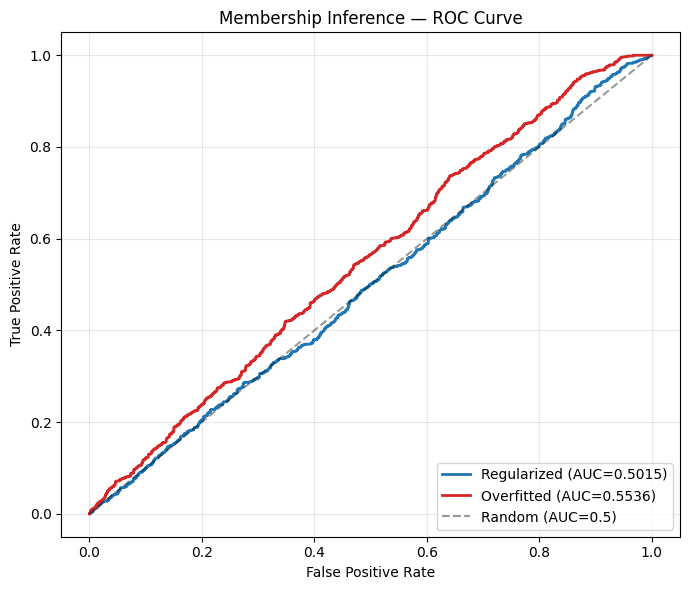

✓ Saved results/plots/roc_curves.png


In [20]:
# 7.1 — Plot 1: ROC Curves (regularized vs overfitted)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(7, 6))

for df, label, color in [
    (df_reg, f"Regularized (AUC={metrics_reg[0]['auc']})", "tab:blue"),
    (df_ovf, f"Overfitted (AUC={metrics_ovf[0]['auc']})", "tab:red"),
]:
    scores = -df["nll"].values
    labels = df["is_member"].values
    fpr, tpr, _ = roc_curve(labels, scores)
    ax.plot(fpr, tpr, label=label, color=color, linewidth=2)

ax.plot([0, 1], [0, 1], "k--", alpha=0.4, label="Random (AUC=0.5)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Membership Inference — ROC Curve")
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)
fig.tight_layout()
fig.savefig("results/plots/roc_curves.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved results/plots/roc_curves.png")

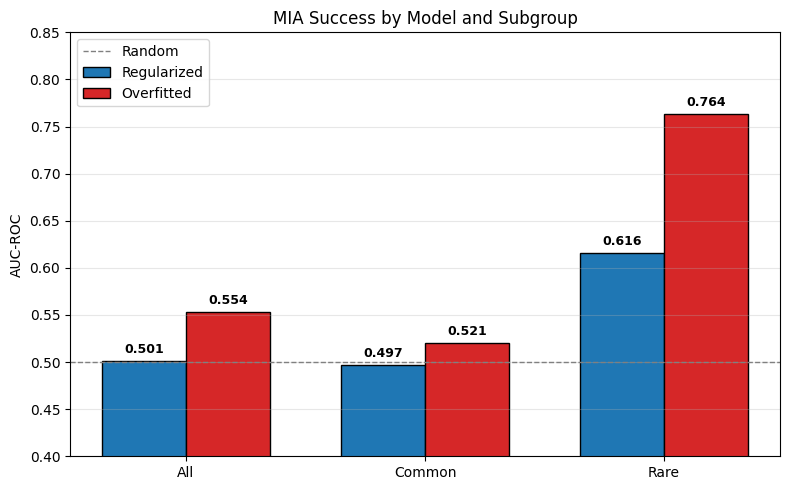

✓ Saved results/plots/auc_comparison.png


In [21]:
# 7.2 — Plot 2: AUC Bar Chart (All / Common / Rare × model)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

subsets = ["all", "common", "rare"]
x = np.arange(len(subsets))
width = 0.35

aucs_reg = [m["auc"] or 0 for m in metrics_reg]
aucs_ovf = [m["auc"] or 0 for m in metrics_ovf]

bars1 = ax.bar(x - width / 2, aucs_reg, width, label="Regularized", color="tab:blue", edgecolor="black")
bars2 = ax.bar(x + width / 2, aucs_ovf, width, label="Overfitted", color="tab:red", edgecolor="black")

ax.axhline(y=0.5, color="gray", linestyle="--", linewidth=1, label="Random")
ax.set_xticks(x)
ax.set_xticklabels([s.capitalize() for s in subsets])
ax.set_ylabel("AUC-ROC")
ax.set_title("MIA Success by Model and Subgroup")
ax.set_ylim(0.4, 0.85)
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

# Value labels
for bars in [bars1, bars2]:
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, h + 0.005, f"{h:.3f}",
                ha="center", va="bottom", fontsize=9, fontweight="bold")

fig.tight_layout()
fig.savefig("results/plots/auc_comparison.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved results/plots/auc_comparison.png")

In [ ]:
# 7.3 — Plot 3: Training Curves (train NLL vs val NLL per epoch)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, (name, metrics, color) in zip(axes, [
    ("Regularized", reg_metrics, "tab:blue"),
    ("Overfitted", ovf_metrics, "tab:red"),
]):
    epochs_list = [m["epoch"] for m in metrics]
    train_nlls = [m.get("train_nll") for m in metrics]
    val_nlls = [m.get("val_nll") for m in metrics]

    if any(v is not None for v in train_nlls):
        valid = [(e, v) for e, v in zip(epochs_list, train_nlls) if v is not None]
        ax.plot([e for e, _ in valid], [v for _, v in valid],
                "o-", color=color, label="Train NLL")
    if any(v is not None for v in val_nlls):
        valid = [(e, v) for e, v in zip(epochs_list, val_nlls) if v is not None]
        ax.plot([e for e, _ in valid], [v for _, v in valid],
                "s--", color="tab:orange", label="Val NLL")

    ax.set_xlabel("Epoch")
    ax.set_ylabel("NLL (Loss)")
    ax.set_title(f"{name} Model")
    ax.legend()
    ax.grid(True, alpha=0.3)

fig.suptitle("Overfitting Visualization — Train vs Val NLL", fontsize=14)
fig.tight_layout()
fig.savefig("results/plots/training_curves.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved results/plots/training_curves.png")

---
## Phase 8 — Validation & Sanity Checks

In [ ]:
# 8.1 — Sanity Check 1: Shuffled Labels Baseline
# If the attack is real, shuffled labels should give AUC ≈ 0.5

set_seed(SEED)

print("=" * 60)
print("SANITY CHECK 1 — Shuffled Labels")
print("=" * 60)

n_trials = 100
shuffled_aucs = []

for _ in range(n_trials):
    shuffled_labels = np.random.permutation(df_ovf["is_member"].values)
    auc_shuf = roc_auc_score(shuffled_labels, -df_ovf["nll"].values)
    shuffled_aucs.append(auc_shuf)

mean_shuf = np.mean(shuffled_aucs)
std_shuf = np.std(shuffled_aucs)
print(f"  Shuffled AUC ({n_trials} trials): {mean_shuf:.4f} ± {std_shuf:.4f}")
print(f"  Expected: ~0.5")
if 0.45 < mean_shuf < 0.55:
    print("  ✓ PASS — shuffled baseline is near random")
else:
    print("  ✗ FAIL — shuffled baseline deviates from 0.5")

In [ ]:
# 8.2 — Sanity Check 2: Pretrained (non-finetuned) Baseline
# A model that was never fine-tuned should have no membership signal → AUC ≈ 0.5

print("=" * 60)
print("SANITY CHECK 2 — Pretrained Baseline (no fine-tuning)")
print("=" * 60)

pretrained_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(DEVICE)
pretrained_model.eval()
pretrained_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
pretrained_tokenizer.pad_token = pretrained_tokenizer.eos_token

pretrained_nlls = []
pretrained_labels = []
pretrained_groups = []

for record in tqdm(eval_pool, desc="Pretrained MIA"):
    nll = compute_nll(pretrained_model, pretrained_tokenizer, record["text"], DEVICE)
    pretrained_nlls.append(nll)
    pretrained_labels.append(record["is_member"])
    pretrained_groups.append(record["group"])

auc_pretrained = roc_auc_score(pretrained_labels, [-n for n in pretrained_nlls])
print(f"  Pretrained AUC: {auc_pretrained:.4f}")
print(f"  Expected: ~0.5")
if 0.45 < auc_pretrained < 0.55:
    print("  ✓ PASS — pretrained model has no membership signal")
else:
    print("  ⚠ WARN — pretrained AUC deviates from 0.5 (investigate template bias)")

del pretrained_model
torch.cuda.empty_cache()

In [ ]:
# 8.3 — Sanity Check 3: NLL Distribution Histograms

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (df, title) in zip(axes, [
    (df_reg, "Regularized"),
    (df_ovf, "Overfitted"),
]):
    members = df[df["is_member"] == 1]["nll"]
    nonmembers = df[df["is_member"] == 0]["nll"]

    ax.hist(members, bins=40, alpha=0.6, label=f"Members (μ={members.mean():.3f})", color="tab:blue")
    ax.hist(nonmembers, bins=40, alpha=0.6, label=f"Non-members (μ={nonmembers.mean():.3f})", color="tab:red")
    ax.axvline(members.mean(), color="tab:blue", linestyle="--", linewidth=2)
    ax.axvline(nonmembers.mean(), color="tab:red", linestyle="--", linewidth=2)
    ax.set_xlabel("NLL")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{title} Model — NLL Distribution")
    ax.legend()
    ax.grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig("results/plots/nll_distributions.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved results/plots/nll_distributions.png")

In [ ]:
# 8.4 — Save sanity check results

sanity_results = {
    "shuffled_labels": {
        "mean_auc": round(float(mean_shuf), 4),
        "std_auc": round(float(std_shuf), 4),
        "n_trials": n_trials,
        "pass": bool(0.45 < mean_shuf < 0.55),
    },
    "pretrained_baseline": {
        "auc": round(float(auc_pretrained), 4),
        "pass": bool(0.45 < auc_pretrained < 0.55),
    },
}

# Append to metrics summary
with open("results/metrics_summary.json", "r") as f:
    full_metrics = json.load(f)
full_metrics["sanity_checks"] = sanity_results
with open("results/metrics_summary.json", "w") as f:
    json.dump(full_metrics, f, indent=2)

print("✓ Sanity check results appended to results/metrics_summary.json")
print(json.dumps(sanity_results, indent=2))

In [ ]:
# 8.5 — Final Summary

print("\n" + "=" * 60)
print("EXPERIMENT COMPLETE")
print("=" * 60)

print("\nResults files:")
for f in [
    "results/regularized_scores.csv",
    "results/overfitted_scores.csv",
    "results/metrics_summary.json",
    "results/training_logs.json",
    "results/plots/roc_curves.png",
    "results/plots/auc_comparison.png",
    "results/plots/training_curves.png",
    "results/plots/nll_distributions.png",
]:
    exists = "✓" if os.path.exists(f) else "✗"
    print(f"  {exists} {f}")

print("\n" + "=" * 60)
print("KEY FINDINGS")
print("=" * 60)

print(f"\nRQ1 — Overfitting → MIA:")
print(f"  Regularized AUC: {metrics_reg[0]['auc']}")
print(f"  Overfitted  AUC: {metrics_ovf[0]['auc']}")

print(f"\nRQ2 — Rare vs Common:")
print(f"  Overfitted Common AUC: {metrics_ovf[1]['auc']}")
print(f"  Overfitted Rare   AUC: {metrics_ovf[2]['auc']}")

print(f"\nSanity Checks:")
print(f"  Shuffled labels:    {'PASS' if sanity_results['shuffled_labels']['pass'] else 'FAIL'}")
print(f"  Pretrained baseline: {'PASS' if sanity_results['pretrained_baseline']['pass'] else 'WARN'}")
print("=" * 60)

In [ ]:
# 8.6 — Download results (Colab only)
try:
    from google.colab import files
    import shutil

    # Zip all results
    shutil.make_archive("mia_results", "zip", ".", "results")
    files.download("mia_results.zip")
    print("✓ Results downloaded as mia_results.zip")
except ImportError:
    print("Not on Colab — results are in results/ directory.")